# Ground-to-Satellite Communication 

In [1]:
from gym import Env
from gym.spaces import *
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.signal import savgol_filter

In [2]:
#Starter code for environment: https://github.com/nicknochnack/OpenAI-Reinforcement-Learning-with-Custom-Environment

"""
State of satellite
P: power of satellite
S1: memory in sensor 1
S2: memory in sensor 2
S3: memory in sensor 3
E: electronics of satellite
O: orbital motion of satellite
T: time of the day-> ionosphere behavior

State Space:
S = (P, S1, S2, S3, E, O, T)
P = {100, 99, 98, …, 3, 2, 1, 0}
S1 = {100, 99, 98, …, 3, 2, 1, 0}
S2 = {100, 99, 98, …, 3, 2, 1, 0}
S3 = {100, 99, 98, …, 3, 2, 1, 0}
E = {0, 1} not working / working
O = {0, 1} not in range / in range
T = {0, 1, 2, 3, 4} night, dawn, morning, afternoon, dusk

Action Space:
A = {transmit, not transmit} = {1, 0}

Step Function:
*If a1= transmit = 1, then:
    P(state=s) transitions to a lower value P(state=s’) ---> power discharges
    Ex: P=100 -> a1 (transmit) -> P=95
    S1(state=s) transitions to a lower value S1(state=s’) ---> free memory in sensor 1 decreases (data transferred)
    Ex: S1=100 -> a1 (transmit) -> S1=96.5

*If a1= not transmit = 0, then:
    P(state=s) transitions to a higher value P(state=s’) ---> power charges
    Ex: P=70 -> a1 (not transmit) -> P=73
    S1(state=s) remains the same S1(state=s’) ---> free memory in sensor 1 constant (no data transferred)
    Ex: S1=70 -> a1 (not transmit) -> S1=70

Reward:
*If a1=1 (transmit), then:    ---> For each transmission we get reward
    reward +=5 
*If P(state=s’)>=30, then:    ---> Rewards for maintaining power more than 30%
    reward +=2 
*If we transmit all the data within the time satellite is within range then:
    reward += 5*(remaining time for satellite in range)  --->More rewards for quicker transmission

Termination:
An action can occur every minute for an hour (when the satellite is within range) or until the sensor memory is full i.e. terminate if:
*S1(state=s) = 0 --->Transmission complete
*O(state=s) = 0  --->Satellite out of range

"""

class SatelliteEnv(Env):
    def __init__(self):
        # A = {transmit, not transmit} = {1, 0}
        self.action_space = Discrete(2)
        # S = (P, S1, S2, S3, E, O, T)
        #Note currently only using P,S1,O
        self.observation_space = Tuple((Box(0, 100, shape=(2,)),MultiDiscrete([2])))
        # Set start states
        self.state = np.zeros(3)
        for i in range(3): 
            if i<2:
                self.state[i] = 100
            else:
                self.state[i] = 1
        
        #Transmission Time 60 mins
        self.transmission_time = 60
        
    def step(self, action):
        #A = {transmit, not transmit} = {1, 0}
        #Update States

        if self.state[0]>=5: #no action 1 if P < 5 
            if action==1:
                self.state[0] += -5   #discharging
                self.state[1] += -3   #update free memory
        if action==0:
            self.state[0] += +3 #charging
            
        #Check States within bounds
        for i in range(2):
            if self.state[i]>100:
                self.state[i] = 100  
            elif self.state[i]<0:
                self.state[i] = 0
             
        # Reduce transmission time by 1 minute
        self.transmission_time -= 1
        
        # Calculate reward
        reward = 0
        if self.state[0]>=30:
            reward += 2
        else: 
            reward += 0
        if action==1:
            reward += 5
        if self.state[1]==0:
            reward += 100
        
        # Check if transmission time is done
        if self.transmission_time <= 0:
            self.state[2] = 0
    
        if 0 in self.state[[1,2]]:
            done = True
        else:
            done = False
        
        # Set Information
        info = {}
        
        # Return step information
        return self.state, reward, done, info

    def render(self):
        # Implement visualization
        pass
    
    def reset(self):
        # Reset states
        self.state = np.zeros(3)
        for i in range(3): 
            if i<2:
                self.state[i] = 100 #random.randint(90,100)
            else:
                self.state[i] = 1
        # Reset time
        self.transmission_time = 60 
        return self.state
    

In [3]:
env = SatelliteEnv()

A = np.arange(2)
P = np.arange(0,101,1)
S1 = np.append([0],np.arange(1,101,3)) #based on discharge rate! currently -3!
O = np.arange(2) 
A = np.arange(2)
state = np.array([P,S1,O])
N = np.size(state[0])*np.size(state[1])*np.size(state[2])
Q = np.zeros((np.size(A),N))


rew_iter=[]

S_lookup = np.zeros([N,3])
i = 0
for l in range(np.size(state[0])):
    for m in range(np.size(state[1])):
        for n in range(np.size(state[2])):
            S_lookup[i] = [state[0][l],state[1][m],state[2][n]]
            i = i + 1
S_lookup = S_lookup.astype(int)
dims = S_lookup.max(0)+1


alpha = 0.6
gamma = 0.95
eps = 0.5

episodes = 3000
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    old_state = N - 1
    old_action = 1

    A = np.arange(env.action_space.n)
 
    while not done:
        #env.render()
        #Epsilon Greedy (choose action)
        if np.random.random()<eps:
            new_action = np.random.choice(A)
        else:
            new_action = np.argmax(Q[:,old_state]) ###WARNING!! argmax always returns action 0 if Q is initally zeros!

        n_state, reward, done, info = env.step(old_action)
        n_state = n_state.astype(int)
        new_state = np.where(np.in1d(np.ravel_multi_index(S_lookup.T,dims),np.ravel_multi_index(n_state.T,dims)))[0][0]

        #Q[old_action,old_state]+=alpha*(reward+gamma*np.max(Q[:,new_state])-Q[old_action,old_state]) #Q-Learning
        
        Q[old_action,old_state]+=alpha*(reward+gamma*(Q[new_action,new_state])-Q[old_action,old_state]) #SARSA
        old_state = new_state
        old_action = new_action
        score+=reward
    rew_iter.append(score)
    if episode%1000==0:
        print(episode)
    if (episode)==episodes/2:
        eps=0

#     out_states = ','.join(map('{:6}'.format, n_state[[0,1,2]]))
#     print('Episode:{0:3}   Score:{1:5,.1f}   Transmissions:{2:4}   Total Time:{3:4}   Final States(P,S1,O):{4:5}'.format(episode,score,a.count(1),np.size(a),out_states))


1000
2000
3000


Text(0.5, 1.0, 'SARSA')

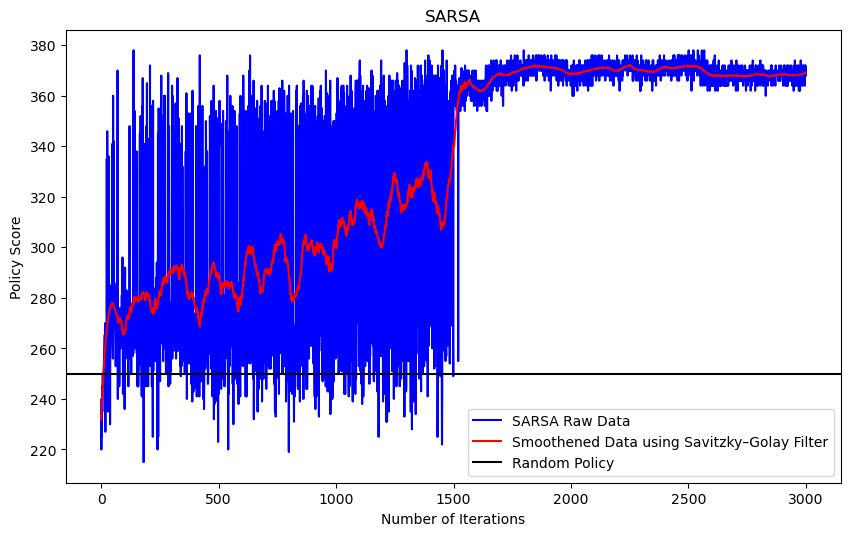

In [4]:
plt.figure(figsize=(10,6), dpi=100)
plt.plot(np.arange(np.size(rew_iter)),rew_iter,'b',label="SARSA Raw Data")
Y2 = savgol_filter(rew_iter, 101, 3)
plt.plot(np.arange(np.size(rew_iter)),Y2,'r',label="Smoothened Data using Savitzky–Golay Filter")
plt.axhline(y = 245, color = 'black',label="Random Policy")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Policy Score")
plt.title("SARSA")

In [5]:
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    a=[]
    
    new_state = N-1
    while not done:
        #env.render() 
        
        action = np.argmax(Q[:,new_state])
        n_state, reward, done, info = env.step(action)
        n_state = n_state.astype(int)
        new_state = np.where(np.in1d(np.ravel_multi_index(S_lookup.T,dims),np.ravel_multi_index(n_state.T,dims)))[0][0]
        a.append(action)
        score+=reward
 
    out_states = ','.join(map('{:6}'.format, n_state[[0,1,2]]))
    print('Episode:{0:3}   Score:{1:5,.1f}   Transmissions:{2:4}   Total Time:{3:4}   Final States(P,S1,O):{4:5}'.format(episode,score,a.count(1),np.size(a),out_states))


Episode:  1   Score:374.0   Transmissions:  34   Total Time:  58   Final States(P,S1,O):     2,     0,     1


In [6]:
policy = np.zeros(N)
for i in range(N):
    if Q[0,i] == Q[1,i]:
        policy[i] = -1
    else:
        policy[i] = np.argmax(Q[:,i])
        
state = np.array([P,S1,O])
viz = np.zeros([np.size(state[0]),np.size(state[1])])

for i in range(N):
    if S_lookup[i][2]==1:
        viz[S_lookup[i,0],np.where(S1 == S_lookup[i,1])[0][0]] = policy[i]

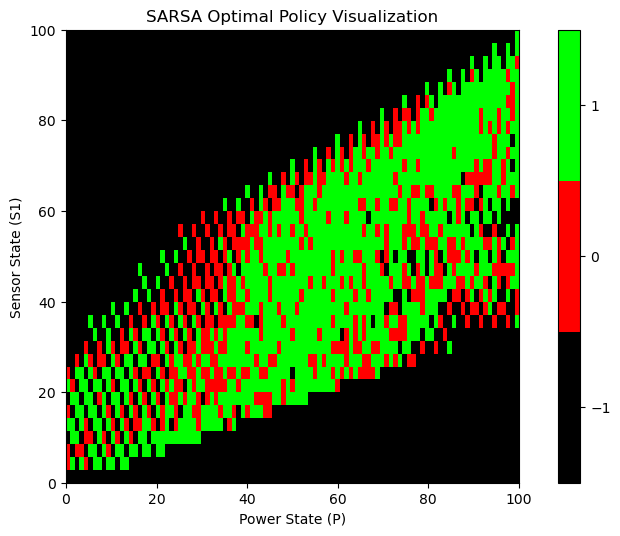

In [7]:
plt.figure(figsize=(10,6), dpi=100)
cmap = mpl.colors.ListedColormap(['black','red',"lime"])
bounds=[-1.5,-0.5,0.5,1.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
img = plt.imshow(np.transpose(viz),interpolation='nearest',cmap = cmap,norm=norm,extent=[0,100,100,0])
plt.ylabel("Sensor State (S1)")
plt.xlabel("Power State (P)")
plt.gca().invert_yaxis()
plt.title("SARSA Optimal Policy Visualization")
plt.colorbar(img,boundaries=bounds,ticks=[-1,0,1])